# Target and Missing Values Analysis

In this step we will have a deeper understanding of the target variable and the missing values present in the data.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from toolkit import Viz, Tools, PF

In [2]:
# Pre configure modules
sns.set()

In [3]:
# Get data
data, target_col, cat_cols, num_cols = PF.import_data()
X, y = data[cat_cols + num_cols], data[target_col]

---
## Target

In [23]:
# Calculate target proportions
target_prop = pd.concat([y.value_counts(), y.value_counts(normalize=True)], axis=1)
target_prop.columns = ['cnt', 'pct']
target_prop

,cnt,pct
0,124387,0.999149
1,106,0.000851


## Target Conclusions
Imbalance
- Target variable is highly unbalanced with a 999:1 ratio.
- In order to prevent model to ignore failure patterns. Sampling strategy must be followed.


Sampling Strategy
- Oversampling by itself can oversaturate data with redundant information from failing devices.
- Under sampling on the other hand may remove important information from non failing (ok) devices.
- Mixing under sampling with bagging (ensemble models) may have a good result. Sampling for each estimator must follow a under sampling strategy. 


Model Requirements
- Best to use estimators that supports probability outcomes (logistic regression, decision trees) to keep a threshold control to optimize results.
- Accuracy isn't a good metric to track for. F1-score and AUROC metrics will guide a better reduction of FN and FP.

---
## Missing Values

### Zero Dense Metrics
- There are zero dense metrics (M2, M3, M4, M7, M8, M9). Where zero values represent more than 90% of metric's data in most cases and 78% for M9.

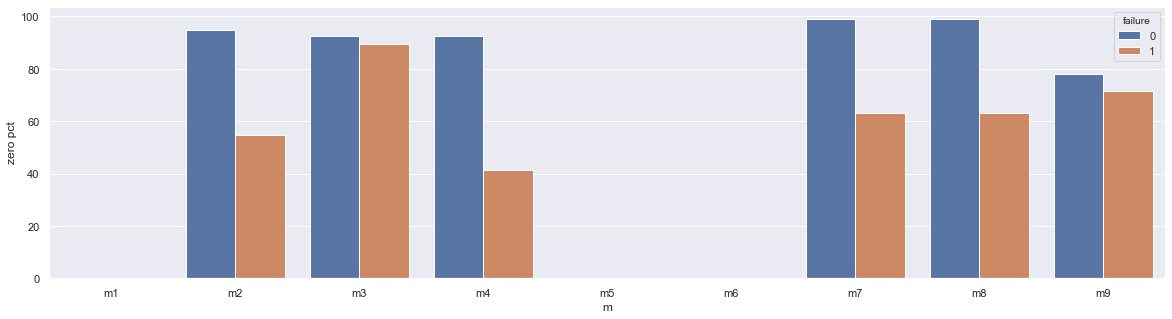

,m1,m2,m3,m4,m5,m6,m7,m8,m9
failure,,,,,,,,,
0,0.01,94.91,92.66,92.54,0,0,98.86,98.86,78.21
1,0.00,54.72,89.62,41.51,0,0,63.21,63.21,71.70


In [6]:
# Check for zero value proportion by target
zero_pct = Tools.get_percentage(data[num_cols], y, values=[0])
mzero_pct = zero_pct.reset_index().melt(id_vars=target_col ,value_vars=num_cols, var_name='m', value_name='zero pct')
sns.barplot(x='m', y='zero pct', hue=target_col, data=mzero_pct, ax=Viz.get_figure(1))
plt.show()
zero_pct

#### Effect of Zero Dense Metrics
- Zero dense metrics adds huge amount of noise in further analysis. It fully changes mean and std for instance. 
- As you can see down below. We will compare each metric's mean and std with and without removing zero noise.
- Notice how these values have are extremely different for zero dense metrics.
- Focus on M2, M3, M4, M7, M8, M9 columns

In [17]:
# Check for non zero mean and std on all metrics separated by target
def mean_nz(c): return c[c > 0].mean()
def std_nz(c): return c[c > 0].std()

m_nzstats = data[num_cols + [target_col]].groupby(target_col)
m_nzstats = m_nzstats.agg([mean_nz, std_nz])

# Check for mean and std on all metrics separated by target
m_stats = data[num_cols + [target_col]].groupby(target_col)
m_stats = m_stats.agg(['mean', 'std'])

pd.concat([m_nzstats.stack(), m_stats.stack()]).sort_index()

m1            m2          m3          m4  \
failure                                                               
0       mean     1.223835e+08    156.119980    9.945678    1.696061   
        mean_nz  1.223943e+08   3064.914141  135.588886   22.743424   
        std      7.046037e+07   2145.530544  185.824848   22.164404   
        std_nz   7.045408e+07   9025.960125  673.622796   78.163315   
1       mean     1.271755e+08   4109.433962    3.905660   54.632075   
        mean_nz  1.271755e+08   9075.000000   37.636364   93.403226   
        std      6.940167e+07  12803.747239   31.557213  193.492528   
        std_nz   6.940167e+07  17894.652409   95.184319  246.503713   

                        m5             m6          m7          m8          m9  
failure                                                                        
0       mean     14.221663  260174.624213    0.266684    0.266684   12.442562  
        mean_nz  14.221663  260174.624213   23.377026   23.377026   57.097801  
        std      15.943435   99148.154087    6.558098    6.558098  191.455782  
        std_nz   15.943435   99148.154087   56.851186   56.851186  407.017197  
1       mean     15.462264  258303.481132   30.622642   30.622642   23.084906  
        mean_nz  15.462264  258303.481132   83.230769   83.230769   81.566667  
        std      15.547270  103349.308593  117.033610  117.033610  153.449984  
        std_nz   15.547270  103349.308593  182.627383  182.627383  283.410228

### Full Zeros
- Now, let's check for this zero dense columns, what proportion of the instances have only zero across all of them.
- This will help us identify which instances have low quality information. Since they can bias or model when training.

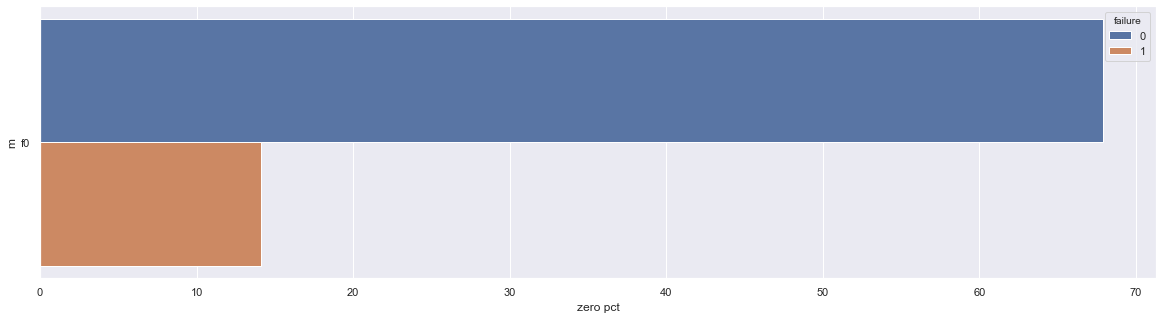

In [20]:
# Check proportion when all measures are zero by target
zd_cols = ['m2', 'm3', 'm4', 'm7', 'm8', 'm9']
full_zero = pd.DataFrame(data[zd_cols].sum(axis=1) == 0, columns=['f0'])
zero_pct = Tools.get_percentage(full_zero, y, values=[True])
mzero_pct = zero_pct.reset_index().melt(id_vars=target_col ,value_vars='f0', var_name='m', value_name='zero pct')
sns.barplot(x='zero pct', y='m', hue=target_col, data=mzero_pct, orient='h', ax=Viz.get_figure(1))
plt.show()

### Full Zeros - Conclusion
- Near 68% of all data has only zero values in zero dense metrics. That’s a lot of noise.
- It is important to mark such rows (F0 mark), to guide a better sampling strategy in exploratory analysis and when building our model. This may help us reduce zero unnecessary noise and better highlight real patterns.

In [22]:
# Add full zero column to data
f0_col = 'f0'
if f0_col not in X.columns: X.insert(X.shape[1], 'f0', full_zero.astype(int))

### Missing Values- Additional Comments
#### Model Requirements
- Since the amount of zero values is too big in most of the metrics (near 90%), trying to fill them by any strategy seems not really helpful. Instead, why not selectively reducing the zero noise when building our model? This will help us keep information as close to reality as possible. 

- When assembling the bagging model (discussed above), the full zero (F0) mark we just created can help us define a stratified under sampling strategy. This will help us control the amount of zero noise in each estimator in the bagg, preventing it from being overwhelmed by zero values.

---
## Under sampling Strategy

### Stratified Under sampling Concept

Taking in consideration the conclusions from the previous section, we need to frame a under sampling strategy that:

- Uses most of the available data in the whole dataset to avoid losing valuable information.
- Help us selectively sample data (without affecting randomness) so that we can filter the amount of zero noise that enters to our model's training phase. This will grant us that the model is fed with mostly relevant information to effectively identify relevant patterns.

Based on these requirements, the following figure illustrates the strategy to be followed:

![Fig 1: Stratified Under Sample Strategy](images/Stratified_Undersample.png)

As you can see the strategy is conformed of the following steps:

- Define a **Strata** for each instance.
    - **Strata 0:** Target = 0 (OK) and Full Zero Mark = 1 (Near to 67 % of data. Does not add much info since all zero dense metrics are 0)
    - **Strata 1:** Target = 0 (OK) and Full Zero Mark = 0 (Near to 33 % of data. Adds important info for non failure patterns)
    - **Strata 2:** Target = 1 (Fail, near 0.1 % of data. Is all available info for failure data.)
- Define strata proportions in under sample.
    - In this case the driver was the desired proportion for failing devices (Strata 2). We randomly chose 30% in under sample, since we want to let each under sample have a greater amount of strata 1 data as possible.
    - This proportions can be tested later to get the best option.
    - Note that each subsample is considerably smaller in proportion to original data. This must be taken care of by bagging model.
- Define a bagging model.
    - Bagging can compensate for the size reduction of under samples. The number of estimators in the model must try to cover as much original data as possible (mainly for strata 1).
    - To ensure even more that most Strata 1 data is used. **Bootstrapping will be disabled**.
    - Remember that this is an under-sample approach. This means that **all samples will have all Strata 2 data**. Think of it as if each estimator will try to analyze all failing data with a small view (perspective) of non-failing (ok) data.
    - Is in the consolidation of all probabilities that will result in the best prediction (**knowledge of the crowds**).

One consequence from this approach is that the new problem will be a multiclass problem, not a binary one, since the objective now will be to predict the strata instead of the target.

- This means a couple of challenges when building, tuning and scoring the model. Each challenge will be assessed as is presented.
- The transformation of probabilities to return to the original problem is straightforward. Just add Strata 0 and Strata 1 for Target 0 and all Strata 2 is Target 1.

### Getting data ready for Under sampling Strategy

In [24]:
# Calculating strata for original data
strt = pd.Series([0] * X.shape[0], index=X.index)
strt[(y == 0) & (X[f0_col] == 0)] = 1
strt[(y == 1)] = 2

# Calculate strata proportions
strt_prop = pd.concat([strt.value_counts(), strt.value_counts(normalize=True)], axis=1)
strt_prop.columns = ['cnt', 'pct']
strt_prop

,cnt,pct
0,84452,0.678367
1,39935,0.320781
2,106,0.000851


#### Getting a stratified under sample

The following functions were built on `Tools` class of **toolkit.py** to facilitate the definition of strata counts in a under sample and the execution of one if required (I encourage you to check it out!):

```python
def strat_undersample_counts(cls, strt, strata_p, cv=False):
        """ Calculates number of instances per strata for a stratified undersample.
        """

def stratified_undersample(cls, X, strt, strata_p, random_state=0):
        """ Gets a stratified under sample for X based on strata proportions.
        """
```

In [25]:
# Getting a Stratified Under Sample
strata_p = {0: 0.1, 1: 0.6, 2: 0.3}
random_state = 0

Xrs, strt_rs = Tools.stratified_undersample(X, strt, strata_p, random_state)
yrs = y.loc[Xrs.index]

In [27]:
# Check Undersample Dimensions
Xrs.shape

(353, 12)

In [28]:
# Check Undersample Strata Proportions
strt_prop = pd.concat([strt_rs.value_counts(), strt_rs.value_counts(normalize=True)], axis=1)
strt_prop.columns = ['cnt', 'pct']
strt_prop

,cnt,pct
1,212,0.600567
2,106,0.300283
0,35,0.099150


In [31]:
# Check Undersample Target Proportions
trgt_prop = pd.concat([yrs.value_counts(), yrs.value_counts(normalize=True)], axis=1)
trgt_prop.columns = ['cnt', 'pct']
trgt_prop

,cnt,pct
0,247,0.699717
1,106,0.300283


## Under sampling - Conclusions
 
Under sampling strategy
- Under sample will always have all Strata 2 data. This Strata determines full under sample size.
- Will use a Strata 0, Strata 1 ratio (15:85). This is the same proportion seen in failure devices when full zero mark is present. This will ensure a homogeneous under sample.
- If zero noise is still an obstacle, Strata 0 proportion may be reduced. In general, different proportion combinations will be tested.
- IMPORTANT: For data exploration, working with a single sample may bias conclusions since much information for non-failure devices (ok) is omitted. But it will help focus on failing devices patterns.

Model Prerequisites
-Stratified under sampling strategy will be followed for estimators in bagging model.
- A coherent number of estimators will compensate the under sampling effect on non-failing devices (ok) information.
- The Knowledge of Crowds principle will be leveraged by this sampling strategy.